In [1]:
import os, sys, glob

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

import numpy as np

import mne

import matplotlib
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def unfold_raw(raw, window_size=None, stride=None):
    """
    This function unfolds raw MNE object into a list of raw objects
    Args:
        raw: a raw MNE object cropped by rejecting bad segments.
    Returns:
        raw_unfolded: a raw MNE object unfolded by applying a sliding window.
    """
    if window_size is None:
        window_size = int(5 * raw.info['sfreq'])
    if stride is None:
        stride = window_size
    nchans = len(raw.ch_names)
    sig = torch.tensor(raw.get_data(), dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    sig_unf = F.unfold(sig, (nchans, window_size), stride=stride , padding=0)
    sig_unf = sig_unf.permute(0, 2, 1).reshape(-1, sig_unf.shape[-1], nchans, window_size)
    return sig_unf

In [3]:
def rm_repeated_annotations(raw):
    """This functions taskes in raw MNE obejct and removes repeated annotations"""
    annots = raw.annotations.copy()
    annots_drop = []
    for k in annots:
        annots_drop.extend([k for kk in annots if (k['onset'] > kk['onset']) and (k['onset']+k['duration'] < kk['onset']+kk['duration']) ])

    annots_updated = [i for i in annots if i not in annots_drop]
    onsets = [i['onset'] for i in annots_updated]
    durations = [i['duration'] for i in annots_updated]
    descriptions = [i['description'] for i in annots_updated]
    print('Initial num of annots: %d  Num of removed annots: %d  Num of retained annots:  %d' % (len(annots), len(annots_drop), len(annots_updated)))
    print(f' New annots: {annots_updated}')
    raw.set_annotations(mne.Annotations(onsets, durations, descriptions) ) 
    return raw

## Read Data

In [4]:
subj_ids = [1, 2, 3]
fs = 128
window_size = int(5 * fs)
stride_size_train, stride_size_val, stride_size_test = int(2.5 * fs), int(2.5 * fs), int(2.5 * fs)
n_channs = 129 # 128 for eeg, 1 for env
batch_size = 64
print('-------------------------------------')
print(f'window_size: {window_size}  stride_size_test: {stride_size_test}')

dataset_name = ['rochester_data', 'natural_speech']
outputs_path = f'../outputs/'
data_path = os.path.join(outputs_path, dataset_name[0], dataset_name[1])
print(f'data_path: {data_path}')

-------------------------------------
window_size: 640  stride_size_test: 320
data_path: ../outputs/rochester_data/natural_speech


In [5]:
raws_train_windowed, raws_val_windowed, raws_test_windowed = [], [], []

for subj_id in subj_ids:
    subj_path = os.path.join(data_path, f'subj_{subj_id}')

    # load subject raw MNE object
    raw = mne.io.read_raw(os.path.join(subj_path, 'after_ica_raw.fif'), preload=True)
    # drop M1 and M2 channels
    raw.drop_channels(['M1', 'M2'])
    assert raw.info['nchan'] == n_channs

    raw = rm_repeated_annotations(raw)
    annots = raw.annotations.copy()
    raw_split = [raw.copy().crop(t1, t2) for t1, t2 in zip(annots.onset[:-1]+annots.duration[:-1], annots.onset[1:])]

    # Pick the split with the longest duration for validation, supposedly less noisy
    ix_val = np.argmax([i.get_data().shape[1] for i in raw_split])
    raw_val = [raw_split.pop(ix_val)] # create a list to make it iterable. later may be used for multiple splits

    # Pick the next split with the longest duration for testing, supposedly less noisy
    ix_test = np.argmax([i.get_data().shape[1] for i in raw_split])
    raw_test = [raw_split.pop(ix_test)]
    
    # creat list of unfolded tensor raw objects
    fs = raw.info['sfreq']
    raws_train_windowed.extend([unfold_raw(i, window_size=window_size, stride=stride_size_train) for i in raw_split if i.get_data().shape[1] > window_size])
    raws_val_windowed.extend([unfold_raw(i, window_size=window_size, stride=stride_size_val) for i in raw_val if i.get_data().shape[1] > window_size])
    raws_test_windowed.extend([unfold_raw(i, window_size=window_size, stride=stride_size_test) for i in raw_test if i.get_data().shape[1] > window_size])
    print("-------------------------------------")
    print('N train: %d  N val: %d  N test: %d' % (len(raws_train_windowed), len(raws_val_windowed), len(raws_test_windowed)))

# concatenate all in second dimension
sigs_train = torch.cat(raws_train_windowed, dim=1).permute(1, 0, 2, 3)
sigs_val = torch.cat(raws_val_windowed, dim=1).permute(1, 0, 2, 3)
sigs_test = torch.cat(raws_test_windowed, dim=1).permute(1, 0, 2, 3)
print(f"Shape Trian: {sigs_train.shape}  Shape Val: {sigs_val.shape}  Shape Test: {sigs_test.shape}")

eegs_train = sigs_train[:, :, :-1, :]
eegs_val = sigs_val[:, :, :-1, :]
eegs_test = sigs_test[:, :, :-1, :]
print("-------------------------------------")
print(f"Shape EEG Train: {eegs_train.shape}  Val: {eegs_val.shape}  Test: {eegs_test.shape}")

# To avoid information leakage, we estimate the mean and std from the training set only.
mean_eeg_train =  eegs_train.mean()
std_eeg_train = eegs_train.std()
print(f"Mean: {mean_eeg_train}  Std: {std_eeg_train}")

envs_train = sigs_train[:, :, [-1], :]
envs_val = sigs_val[:, :, [-1], :]
envs_test = sigs_test[:, :, [-1], :]
print(f"Shape Env Train: {envs_train.shape}  Val: {envs_val.shape}  Test: {envs_test.shape}")

# Estimate mean and std of the Envelope data set
mean_env_train =  envs_train.mean()
std_env_train = envs_train.std()
print(f"Mean Env: {mean_env_train}  Std Env: {std_env_train}")

# Normalize the data
eegs_train = (eegs_train - mean_eeg_train) / std_eeg_train
eegs_val = (eegs_val - mean_eeg_train) / std_eeg_train
eegs_test = (eegs_test - mean_eeg_train) / std_eeg_train

envs_train = (envs_train - mean_env_train) / std_env_train
envs_val = (envs_val - mean_env_train) / std_env_train
envs_test = (envs_test - mean_env_train) / std_env_train



Opening raw data file ../outputs/rochester_data/natural_speech/subj_1/after_ica_raw.fif...
    Range : 0 ... 464571 =      0.000 ...  3629.461 secs
Ready.
Reading 0 ... 464571  =      0.000 ...  3629.461 secs...
Initial num of annots: 42  Num of removed annots: 19  Num of retained annots:  23
 New annots: [OrderedDict([('onset', 0.0), ('duration', 0.0), ('description', 'bad'), ('orig_time', None)]), OrderedDict([('onset', 176.784332), ('duration', 2.0346832275390625), ('description', 'bad'), ('orig_time', None)]), OrderedDict([('onset', 357.548248), ('duration', 1.66888427734375), ('description', 'bad'), ('orig_time', None)]), OrderedDict([('onset', 537.407166), ('duration', 1.8746337890625), ('description', 'bad'), ('orig_time', None)]), OrderedDict([('onset', 719.272339), ('duration', 0.75445556640625), ('description', 'bad'), ('orig_time', None)]), OrderedDict([('onset', 899.217163), ('duration', 1.8060302734375), ('description', 'bad'), ('orig_time', None)]), OrderedDict([('onset',

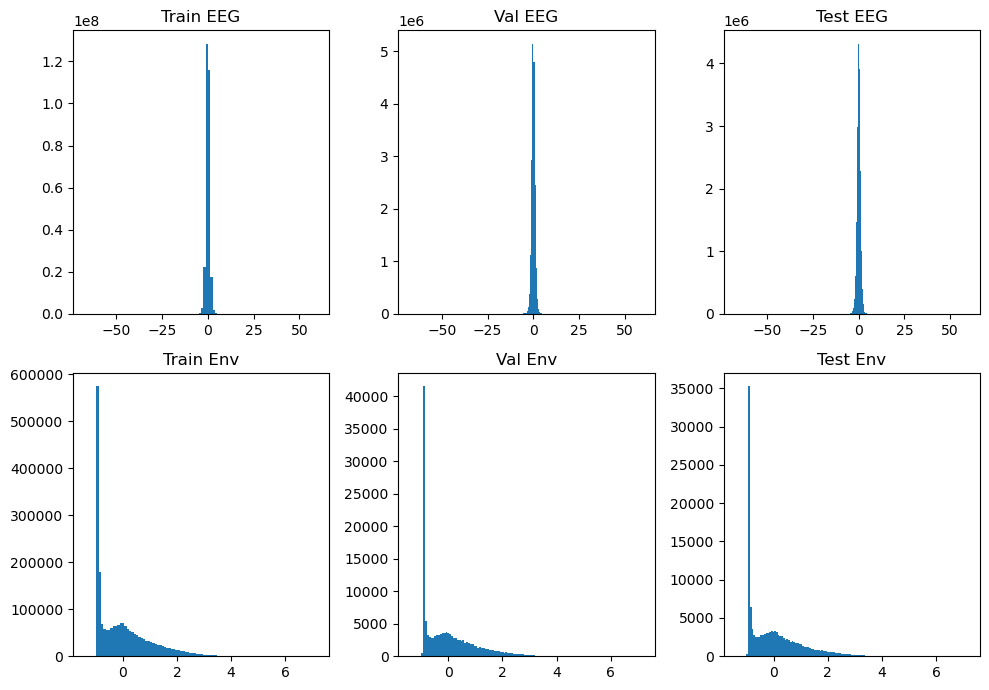

In [6]:
fig, ax = plt.subplots(2, 3, figsize=(10, 7), sharex='row')
ax[0, 0].hist(eegs_train.flatten().numpy(), bins=100);
ax[0, 0].set_title('Train EEG')
ax[0, 1].hist(eegs_val.flatten().numpy(), bins=100);
ax[0, 1].set_title('Val EEG')
ax[0, 2].hist(eegs_test.flatten().numpy(), bins=100);
ax[0, 2].set_title('Test EEG')
ax[1, 0].hist(envs_train.flatten().numpy(), bins=100);
ax[1, 0].set_title('Train Env')
ax[1, 1].hist(envs_val.flatten().numpy(), bins=100);
ax[1, 1].set_title('Val Env')
ax[1, 2].hist(envs_test.flatten().numpy(), bins=100);
ax[1, 2].set_title('Test Env')
plt.tight_layout()
plt.show();

### Pytorch dataloader

In [20]:
class MyDataset(Dataset):
    def __init__(self, eeg, env):
        self.eeg = eeg
        self.env = env
    
    def __getitem__(self, index):
        return self.eeg[index], self.env[index]
    
    def __len__(self):
        return len(self.eeg)
    
dataset_train = MyDataset(eegs_train, envs_train)
dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)

## Model

In [8]:
class Conv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, **kargs):
        super().__init__(in_channels, out_channels, kernel_size, **kargs)

    def __call__(self, inp):
        self.out = super().__call__(inp)

        if self.out.requires_grad:
            self.out.retain_grad()

        return self.out
    
    # -----------------------------------------------------------------------------------------------
class Flatten:
    
  def __call__(self, x):
    self.out = x.view(x.shape[0], -1)
    return self.out
  
  def parameters(self):
    return []
  
  # -----------------------------------------------------------------------------------------------
class Linear(nn.Linear):
    def __init__(self, x, y, **kargs):
        super().__init__(x, y, **kargs)

    def __call__(self, inp):
        self.out = super().__call__(inp)
        return self.out
  # -----------------------------------------------------------------------------------------------
   
class ELU(nn.ELU):
    def __init__(self, alpha=1.0, inplace=False):
        super().__init__(alpha=1.0, inplace=False)

    def __call__(self, inp):
        self.out = super().__call__(inp)
        if self.out.requires_grad:
            self.out.retain_grad()
        return self.out

  # -----------------------------------------------------------------------------------------------
class Sequential:
  
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

    def named_parameters(self):
        # get parameters of all layers and stretch them out into one list
        return ((n, p) for layer in self.layers for n, p in layer.named_parameters())

In [9]:
# My implementation of the shallow convnet

fs = 64 # sampling rate
T = 5 * fs # number of time points in each trial
C = 64 # number of EEG channels
F1 = 8 # number of channels (depth) in the first conv layer
D = 2 # number of spatial filters in the second conv layer
F2 = D * F1 # number of channels (depth) in the pont-wise conv layer
num_classes = 4 # number of classes

shallow_covnet = Sequential([
    Conv2d(1, 40, (1, int(fs//2)), padding='same', bias=True),
    Conv2d(40, 40, (C, 1), padding=(0, 0), bias=False), nn.BatchNorm2d(40, affine=True), 
    nn.AvgPool2d((1, 75), (1, 15)), nn.Dropout(0.5),
    Conv2d(40, 4, kernel_size=(1, 30), padding='same', stride=(1, 1), bias=True),
    nn.Flatten(1, -1), # Flatten start_dim=1, end_dim=-1
    Linear(62*4, 4, bias=True),
])



In [10]:

class EEGEncoder(nn.Module):
    def __init__(self,             
            fs = 128, # sampling rate
            T = 5, # lenght of each trial in seconds
            C = 128, # number of EEG channels
            F1 = 8, # number of channels (depth) in the first conv layer
            D = 2, # number of spatial filters in the second conv layer
            F2 = None # number of channels (depth) in the pont-wise conv layer
        ):
        super(EEGEncoder, self).__init__()

        if F2 is None:
            F2 = D * F1

        self.eeg_encoder = nn.Sequential(
            Conv2d(1, F1, (1, int(fs/2)), padding='same', bias=True, groups=1),
            nn.BatchNorm2d(F1, affine=True),
            Conv2d(F1, out_channels=D*F1, kernel_size=(C, 1), padding=(0, 0), bias=False, groups=F1),

            nn.BatchNorm2d(D*F1, affine=True), ELU(), nn.AvgPool2d(1, 2), #nn.Dropout(0.5),
                    
            Conv2d(F2, F2, (1, int(fs/(2*4))), padding='same', bias=False, groups=D*F1),
            Conv2d(D*F1, F2, kernel_size=(1, 1), padding=(0, 0), groups=1, bias=False),
            nn.BatchNorm2d(F2, affine=True), ELU(), nn.AvgPool2d(1, 4), #nn.Dropout(0.5),

            nn.Flatten(),
            nn.Linear(F2*int((T*fs)//(2*4)), fs)
        ) 

    @torch.no_grad()
    def normalize_weights_eegnet(self):

        for name, param in self.eeg_encoder.named_parameters():
            if  name == 'weight' and param.ndim==4: # normalize conv weights to max norm 1
                param.data = torch.renorm(param.data, 2, 0, maxnorm=1)
                #param.data /=  eps + param.data.norm(2, dim=0, keepdim=True)
            elif name == 'weight' and param.ndim==2: # normalize fc weights to max norm 0.25
                param.data = torch.renorm(param.data, 2, 0, maxnorm=0.25)
                #param.data /=  eps + param.data.norm(2, dim=0, keepdim=True)


    def forward(self, x):
        x = self.eeg_encoder(x)
        return x

eeg_encoder = EEGEncoder()
eeg_encoder.eeg_encoder

# Test the model, add no grad
with torch.no_grad():
    print(eeg_encoder(eegs_train[:32, :, :, :]).shape)

torch.Size([32, 128])


/Users/keyvan.mahjoory/opt/anaconda3/envs/mne/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525699189/work/aten/src/ATen/native/Convolution.cpp:896.)
  return F.conv2d(input, weight, bias, self.stride,


In [11]:
class EnvEncoder(nn.Module):

    def __init__(self,             
            fs = 128, # sampling rate
            T = 5, # lenght of each trial in seconds
            F1 = 8
        ):
        super(EnvEncoder, self).__init__()

        self.env_encoder = nn.Sequential(
            Conv2d(1, F1, (1, int(fs//2)), padding='same', bias=True),
            nn.BatchNorm2d(F1, affine=True), ELU(), nn.AvgPool2d(1, 2),
            Conv2d(F1, F1, (1, int(fs//8)), padding='same', bias=False, groups=F1),
            nn.BatchNorm2d(F1, affine=True), ELU(), nn.AvgPool2d(1, 4), 
            nn.Flatten(),
            nn.Linear(F1*int((T*fs)//(2*4)), fs)
        ) 

    def forward(self, x):
        x = self.env_encoder(x)
        return x

env_encoder = EnvEncoder()
env_encoder.env_encoder

# Test the model, add no grad
with torch.no_grad():
    print(env_encoder(envs_train[:32, :, :, :]).shape)

torch.Size([32, 128])


In [12]:
class CES(nn.Module):
    def __init__(self, 
                 eeg_encoder= eeg_encoder.eeg_encoder,
                 env_encoder = env_encoder.env_encoder): 
        super().__init__()

        self.eeg_encoder = eeg_encoder
        self.env_encoder = env_encoder
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

    def encode_eeg(self, x):
        return self.eeg_encoder(x)
    
    def encode_env(self, x):
        return self.env_encoder(x)
    
    def forward(self, eeg, env):
        eeg_features = self.encode_eeg(eeg)
        env_features = self.encode_env(env)
        return eeg_features, env_features, self.logit_scale.exp()
  

model = CES()
for n,p in model.named_parameters():
    print(n, p.shape)


logit_scale torch.Size([])
eeg_encoder.0.weight torch.Size([8, 1, 1, 64])
eeg_encoder.0.bias torch.Size([8])
eeg_encoder.1.weight torch.Size([8])
eeg_encoder.1.bias torch.Size([8])
eeg_encoder.2.weight torch.Size([16, 1, 128, 1])
eeg_encoder.3.weight torch.Size([16])
eeg_encoder.3.bias torch.Size([16])
eeg_encoder.6.weight torch.Size([16, 1, 1, 16])
eeg_encoder.7.weight torch.Size([16, 16, 1, 1])
eeg_encoder.8.weight torch.Size([16])
eeg_encoder.8.bias torch.Size([16])
eeg_encoder.12.weight torch.Size([128, 1280])
eeg_encoder.12.bias torch.Size([128])
env_encoder.0.weight torch.Size([8, 1, 1, 64])
env_encoder.0.bias torch.Size([8])
env_encoder.1.weight torch.Size([8])
env_encoder.1.bias torch.Size([8])
env_encoder.4.weight torch.Size([8, 1, 1, 16])
env_encoder.5.weight torch.Size([8])
env_encoder.5.bias torch.Size([8])
env_encoder.9.weight torch.Size([128, 640])
env_encoder.9.bias torch.Size([128])


## Model Setup

## Optimization

In [13]:

with torch.no_grad():
    for ix, layer in enumerate(model.eeg_encoder + model.env_encoder):
        if isinstance(layer, nn.Conv2d):
            layer.weight *= 0.1
            if layer.bias is not None:
                layer.bias *= 0


print(sum(p.nelement() for p in model.parameters())) # number of parameters in total
for p in model.parameters():
    p.requires_grad = True

print(model.eeg_encoder)
print(model.env_encoder)


249857
Sequential(
  (0): Conv2d(1, 8, kernel_size=(1, 64), stride=(1, 1), padding=same)
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Conv2d(8, 16, kernel_size=(128, 1), stride=(1, 1), groups=8, bias=False)
  (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): ELU(alpha=1.0)
  (5): AvgPool2d(kernel_size=1, stride=2, padding=0)
  (6): Conv2d(16, 16, kernel_size=(1, 16), stride=(1, 1), padding=same, groups=16, bias=False)
  (7): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ELU(alpha=1.0)
  (10): AvgPool2d(kernel_size=1, stride=4, padding=0)
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): Linear(in_features=1280, out_features=128, bias=True)
)
Sequential(
  (0): Conv2d(1, 8, kernel_size=(1, 64), stride=(1, 1), padding=same)
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_run

In [14]:

print(f" Shape EEG: {dataloader.dataset.eeg.shape}   Env: {dataloader.dataset.env.shape}")
print(f" Batch size: {dataloader.batch_size}")
print(f" Number of batches: {len(dataloader)}")

 Shape EEG: torch.Size([3539, 1, 128, 640])   Env: torch.Size([3539, 1, 1, 640])
 Batch size: 64
 Number of batches: 56


# gradient not getting updateing
maybe because the chain removes the referencing ...

links to check for implementing the loss function:  

https://www.kaggle.com/code/moeinshariatnia/openai-clip-simple-implementation/notebook  


https://github.com/openai/CLIP/issues/83


https://github.com/mlfoundations/open_clip

https://github.com/mlfoundations/open_clip/blob/main/src/open_clip/loss.py

In [15]:
sys.getsizeof(eegs_train.storage())/1e6

1159.659568

In [21]:
num_train = eegs_train.shape[0]
max_steps = 100
lossi = []
udri = [] # update / data ratio 
ud = []

for epoch in range(1, 10):

    model.train()
    for ix_batch, (Xb_eeg, Xb_env) in enumerate(dataloader):

        # forward pass
        eeg_features, env_features, logit_scale = model(Xb_eeg, Xb_env) 

        # normalize features
        eeg_features_n = eeg_features / eeg_features.norm(dim=1, keepdim=True)
        env_features_n = env_features / env_features.norm(dim=1, keepdim=True)

        # logits
        logits_per_eeg = logit_scale * eeg_features_n @ env_features_n.t()
        logits_per_env = logits_per_eeg.t()

        #loss function
        labels = torch.arange(batch_size)
        loss_eeg = F.cross_entropy(logits_per_eeg, labels)
        loss_env = F.cross_entropy(logits_per_env, labels)
        loss   = (loss_eeg + loss_env)/2

        # backward pass
        for p in model.parameters():
            p.grad = None
        loss.backward()

        # update: simple SGD
        lr = 0.01 if epoch < 50 else 0.001 # step learning rate decay
        for p in model.parameters():
            p.data += -lr * p.grad

        # normalize weights
        #with torch.no_grad():
        #    normalize_weights_eegnet(eeg_encoder)

        # track stats
        if ix_batch % 5 == 0:
            print(f'Batch: {ix_batch:7d}: {loss.item():.4f}  {loss_eeg.item():.4f}  {loss_env.item():.4f}   {eeg_features.detach().std().item():.4f}  {env_features.detach().std().item():.4f}')
        lossi.append(loss.log10().item())
        with torch.no_grad():
            ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in model.parameters() ])


    # Validation after each epoch
    model.eval() # set the model in evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        eeg_f, env_f, logit_sc = model(eegs_val, envs_val)
        eeg_f_n = eeg_f / eeg_f.norm(dim=1, keepdim=True)
        env_f_n = env_f / env_f.norm(dim=1, keepdim=True)


        _logits_per_eeg = logit_sc * eeg_f_n @ env_f_n.t()
        _logits_per_env = _logits_per_eeg.t()
        #loss function
        _labels = torch.arange(eegs_val.shape[0])
        _loss_eeg = F.cross_entropy(_logits_per_eeg, _labels)
        _loss_env = F.cross_entropy(_logits_per_env, _labels)
        loss_val   = (_loss_eeg + _loss_env)/2
        print(f"====> Epoch: {epoch:3d}    Validation loss: {loss_val.item():.4f}")

            
    #break    


      0: 3.8953  3.8945  3.8960   0.5065  0.5027
      5: 4.0466  4.0466  4.0466   0.5194  0.4990
     10: 3.9473  3.9453  3.9492   0.5171  0.4961
     15: 4.1083  4.1067  4.1098   0.5025  0.4975
     20: 3.8534  3.8479  3.8588   0.5027  0.4981
     25: 3.9739  3.9733  3.9745   0.5053  0.4904
     30: 3.8513  3.8471  3.8554   0.5025  0.4882
     35: 3.9432  3.9405  3.9459   0.5035  0.4942
     40: 3.6989  3.6940  3.7038   0.5055  0.4847
     45: 4.0664  4.0657  4.0672   0.4972  0.4885
     50: 3.8435  3.8425  3.8445   0.5125  0.4970
====> Validation loss: 5.3089
      0: 3.4437  3.4419  3.4455   0.5161  0.5033
      5: 3.7185  3.7171  3.7199   0.5099  0.5035
     10: 3.7163  3.7103  3.7224   0.5100  0.4906
     15: 3.6928  3.6913  3.6943   0.5086  0.4891
     20: 3.7293  3.7280  3.7306   0.5176  0.4921
     25: 3.7043  3.7049  3.7037   0.5042  0.4864
     30: 3.7060  3.7071  3.7049   0.5172  0.4867
     35: 3.7020  3.6975  3.7064   0.5164  0.4886
     40: 3.7508  3.7482  3.7535   0.511

In [39]:
num_train = eegs_train.shape[0]
max_steps = 100
lossi = []
udri = [] # update / data ratio 
ud = []

for i in range(max_steps):

    model.train()

    # minibatch construct
    #ix = torch.randint(0, num_train, (batch_size,))
    #ix = set_ixs(num_train, batch_size, distance=6)
    Xb_eeg, Xb_env = eegs_train[ix, :, :, :], envs_train[ix, :, :, :] # batch X, Y

    # forward pass
    eeg_features, env_features, logit_scale = model(Xb_eeg, Xb_env) 

    # normalized features
    eeg_features_n = eeg_features / eeg_features.norm(dim=1, keepdim=True)
    env_features_n = env_features / env_features.norm(dim=1, keepdim=True)


    logits_per_eeg = logit_scale * eeg_features_n @ env_features_n.t()
    logits_per_env = logits_per_eeg.t()
    #loss function
    labels = torch.arange(batch_size)
    loss_eeg = F.cross_entropy(logits_per_eeg, labels)
    loss_env = F.cross_entropy(logits_per_env, labels)
    loss   = (loss_eeg + loss_env)/2

    # Non-Binary labels approach
    #logits = (eeg_features @ env_features.T) / 2
    #eegs_similarity = eeg_features_n @ eeg_features_n.T
    #nvs_similarity = env_features_n @ env_features_n.T
    #targets = F.softmax(
    #    (eegs_similarity + envs_similarity) / 2,  dim=-1)
    #loss_eeg = F.cross_entropy(logits, targets)
    #loss_env = F.cross_entropy(logits.T, targets.T)
    #loss =  (loss_eeg + loss_env) / 2.0 # shape: (batch_size)


    # backward pass
    for p in model.parameters():
        p.grad = None
    loss.backward()

    # update: simple SGD
    lr = 0.01 if i < 2000 else 0.001 # step learning rate decay
    #lr = 0.001
    for p in model.parameters():
        p.data += -lr * p.grad

    # normalize weights
    #with torch.no_grad():
    #    normalize_weights_eegnet(eeg_encoder)

    # track stats
    if i % 5 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}  {loss_eeg.item():.4f}  {loss_env.item():.4f}   {eeg_features.detach().std().item():.4f}  {env_features.detach().std().item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in model.parameters() ])

    if i % 10 == 0:
    # Validation
        model.eval() # set the model in evaluation mode
        correct = 0
        total = 0
        with torch.no_grad():
            eeg_f, env_f, logit_sc = model(eegs_val, envs_val)
            eeg_f_n = eeg_f / eeg_f.norm(dim=1, keepdim=True)
            env_f_n = env_f / env_f.norm(dim=1, keepdim=True)


            _logits_per_eeg = logit_sc * eeg_f_n @ env_f_n.t()
            _logits_per_env = _logits_per_eeg.t()
            #loss function
            _labels = torch.arange(eegs_val.shape[0])
            _loss_eeg = F.cross_entropy(_logits_per_eeg, _labels)
            _loss_env = F.cross_entropy(_logits_per_env, _labels)
            loss_val   = (_loss_eeg + _loss_env)/2
            print("====> Validation loss: {:.4f}".format(loss_val.item()))
            
    #break


      0/    100: 4.7059  4.7043  4.7074   0.4812  0.4755
====> Validation loss: 6.0956
     10/    100: 4.7086  4.6945  4.7227   0.5081  0.4751
====> Validation loss: 5.9159
     20/    100: 4.4218  4.4169  4.4266   0.5230  0.4903
====> Validation loss: 5.7842
     30/    100: 4.1849  4.1883  4.1815   0.5276  0.4923
====> Validation loss: 5.6600
     40/    100: 4.1356  4.1305  4.1408   0.5325  0.4934
====> Validation loss: 5.6342


KeyboardInterrupt: 

In [38]:
len(_labels), len(envs_val), env_f.shape, eeg_f.shape, logit_sc.shape

(224, 224, torch.Size([224, 128]), torch.Size([224, 128]), torch.Size([]))

In [61]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking for the function only!
def split_loss(split):
    x, y = {
        'train': (ee, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] # (N, block_size, n_emb)
    x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

split_loss('train')
split_loss('val') 

Parameter containing:
tensor(2.6593, requires_grad=True)

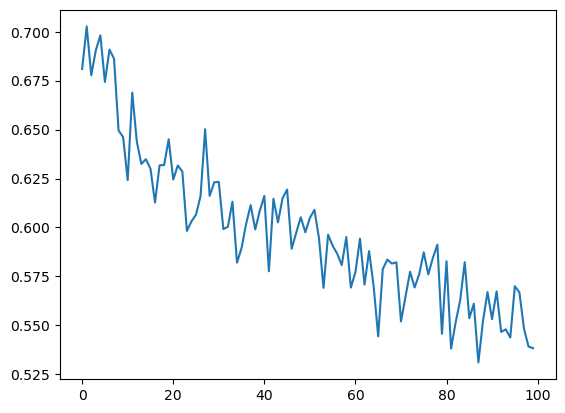

In [27]:
lossi_tensor = torch.tensor(lossi)
plt.plot(lossi_tensor)

In [402]:
print(logits_per_eeg)
counts = logits_per_eeg.exp()
print(counts)
pros = counts / counts.sum(1, keepdim=True)
print(pros)


tensor([[ 0.9977, -0.1030, -0.1398, -0.1248, -0.1276, -0.1139, -0.1309, -0.1159],
        [-0.1101,  0.9981, -0.0727, -0.0412, -0.1044, -0.0895, -0.1038, -0.1165],
        [-0.1394, -0.0662,  0.9969, -0.1151, -0.1180, -0.1231, -0.0947, -0.1137],
        [-0.1209, -0.0250, -0.1258,  0.9973, -0.0867, -0.1009, -0.1046, -0.1218],
        [-0.1232, -0.0755, -0.0884, -0.0788,  0.9973, -0.1125, -0.1074, -0.1115],
        [-0.1285, -0.0984, -0.1470, -0.1291, -0.1362,  0.9977, -0.0753, -0.1556],
        [-0.1453, -0.1185, -0.1389, -0.1443, -0.1636, -0.0633,  0.9968, -0.1241],
        [-0.1103, -0.0928, -0.1115, -0.1133, -0.1148, -0.1242, -0.0966,  0.9972]],
       grad_fn=<MmBackward0>)
tensor([[2.7120, 0.9022, 0.8695, 0.8826, 0.8802, 0.8923, 0.8773, 0.8906],
        [0.8958, 2.7131, 0.9299, 0.9596, 0.9008, 0.9144, 0.9015, 0.8901],
        [0.8699, 0.9359, 2.7100, 0.8913, 0.8887, 0.8842, 0.9097, 0.8925],
        [0.8862, 0.9753, 0.8818, 2.7109, 0.9170, 0.9040, 0.9007, 0.8853],
        [0.8841, 

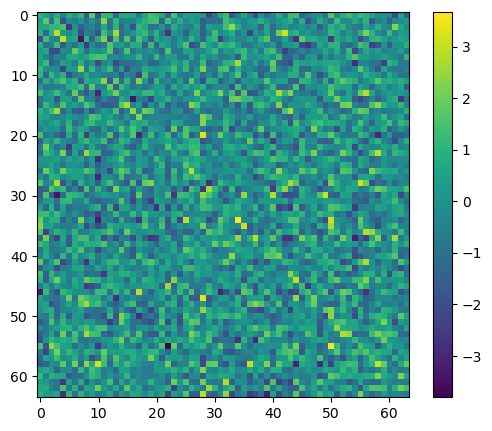

In [28]:
plt.figure(figsize=(6, 5))
plt.imshow(logits_per_eeg.detach().numpy(), aspect='auto')
plt.colorbar()
plt.show()

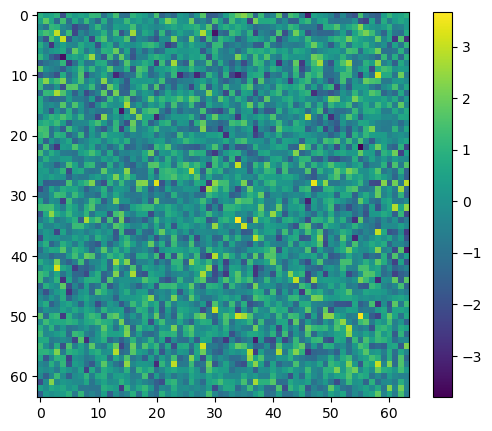

In [29]:
plt.figure(figsize=(6, 5))
plt.imshow(logits_per_env.detach().numpy(), aspect='auto')
plt.colorbar()
plt.show()

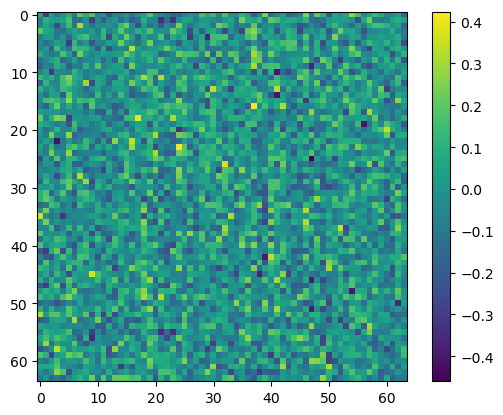

In [221]:
plt.imshow(eeg_features.detach().numpy())
plt.colorbar()

TypeError: Invalid shape (64, 64, 320) for image data

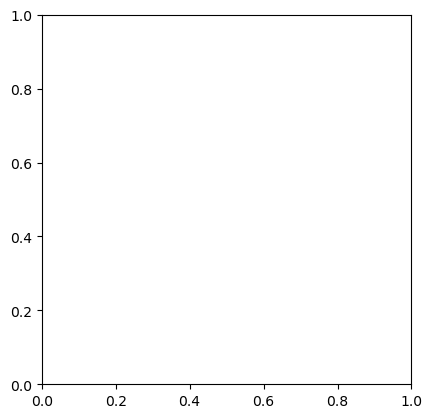

In [227]:
plt.imshow(Xb_eeg.squeeze().numpy())
plt.colorbar()

In [192]:
print( "%.4f, %.4f" % (logits_per_eeg.mean().item(), logits_per_env.mean().item()) )
print( "%.4f, %.4f" % (logits_per_eeg.max().item(), logits_per_env.max().item()) )
print( "%.4f, %.4f" % (logits_per_eeg.min().item(), logits_per_env.min().item()) )
print( "%.4f, %.4f" % (logits_per_eeg.std().item(), logits_per_env.std().item()) )

0.1732, 0.1732
0.1772, 0.1772
0.1693, 0.1693
0.0017, 0.0017


In [109]:
torch.tensor(1/32).log()

tensor(-3.4657)

layer 4 (       ELU):  mean  +0.098448, std 6.123393e-01, range [-9.995818e-01  5.253291e+00]
torch.Size([64, 16, 1, 320])
layer 9 (       ELU):  mean  +0.000006, std 5.543732e-03, range [-2.649647e-02  3.521960e-02]
torch.Size([64, 16, 1, 160])
layer 2 (       ELU):  mean  +0.082368, std 5.338678e-01, range [-9.209993e-01  2.188628e+00]
torch.Size([64, 8, 1, 320])
layer 6 (       ELU):  mean  +0.080532, std 5.527328e-01, range [-8.674114e-01  2.275359e+00]
torch.Size([64, 8, 1, 160])
layer 4 (       ELU):  mean  +0.000000, std 3.678346e-09
layer 9 (       ELU):  mean  -0.000000, std 6.146285e-07
layer 2 (       ELU):  mean  +0.000000, std 1.394169e-05
layer 6 (       ELU):  mean  -0.000000, std 1.717678e-05


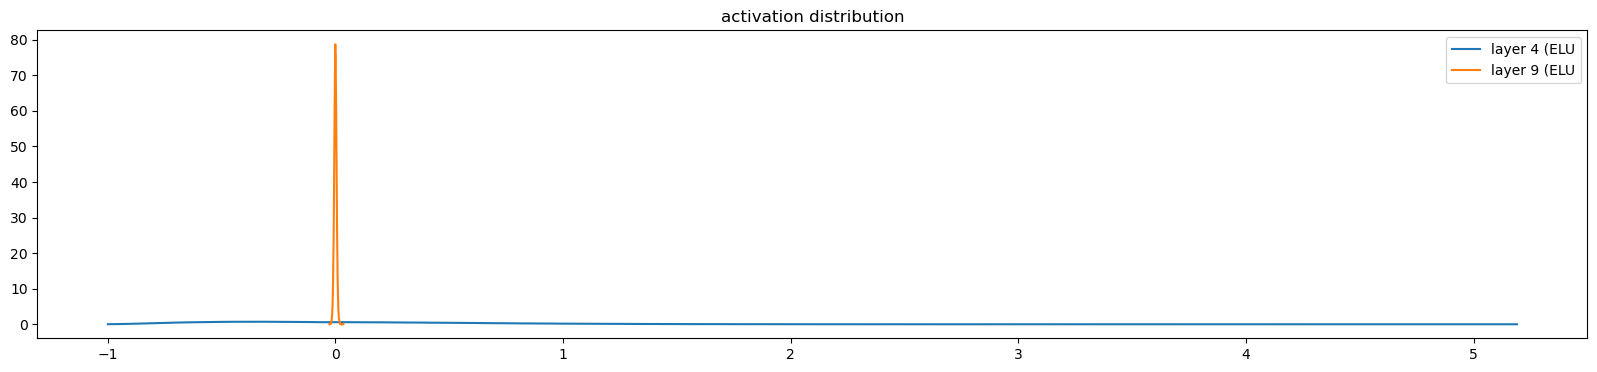

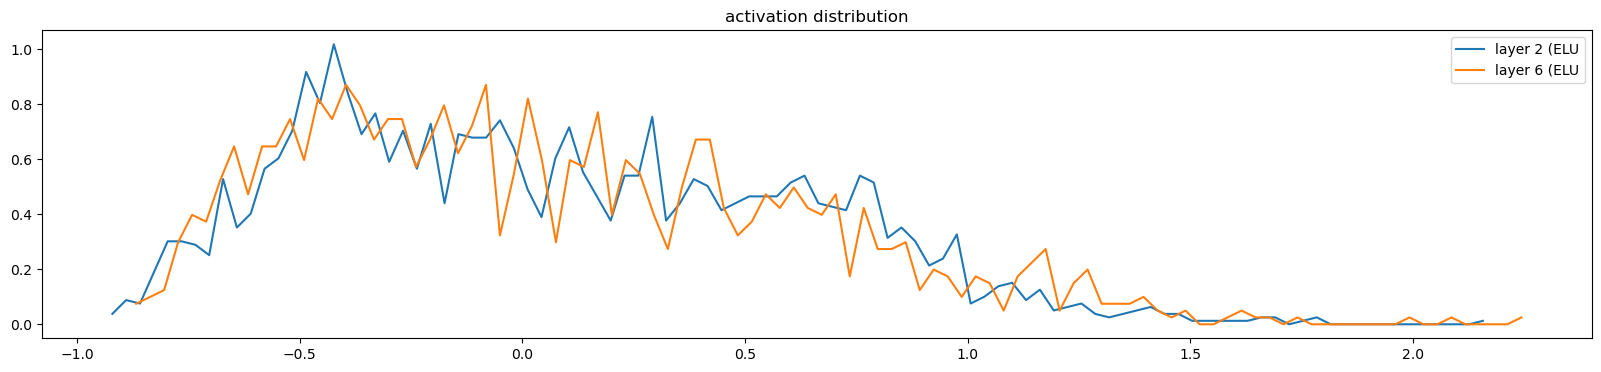

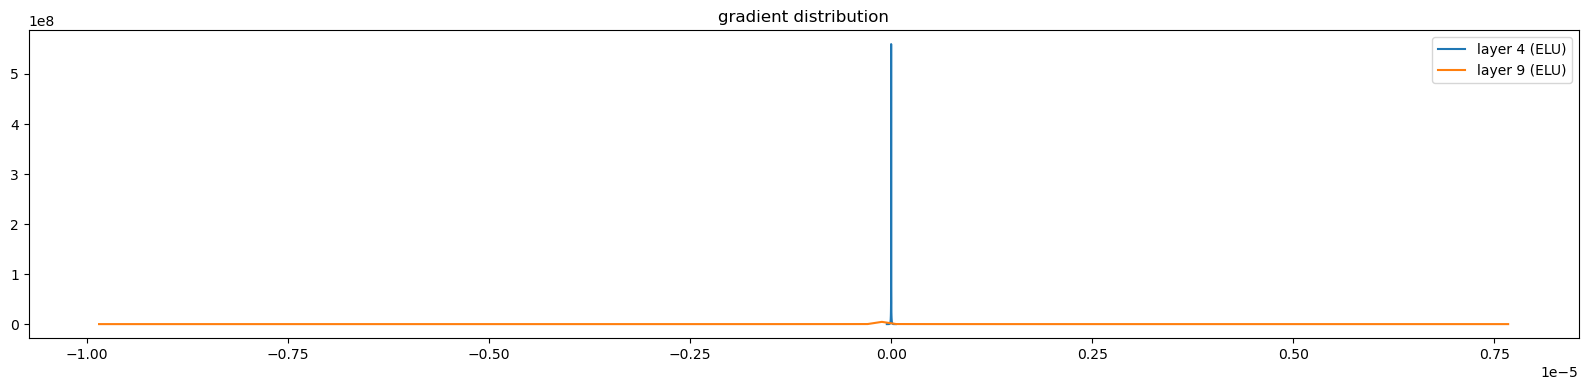

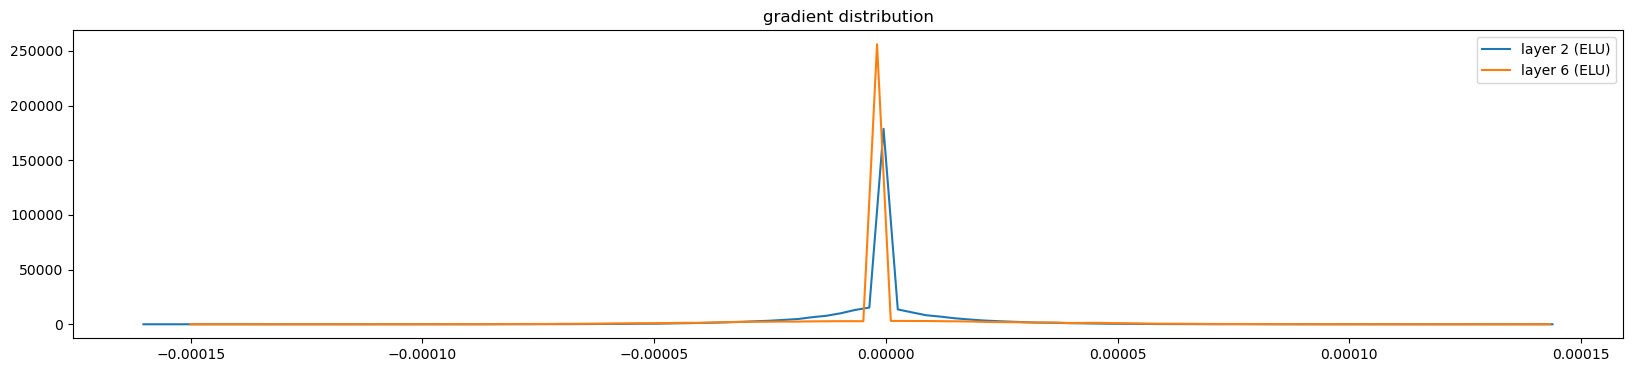

In [158]:
# ELU Activations and their gradients

plt.figure(figsize=(20, 4)); # width and height of the plot
legends = []
for i, layer in enumerate(eeg_encoder[:-1]): # note: exclude the output layer
    if isinstance(layer, (ELU)):
        t = layer.out
        print('layer %d (%10s):  mean  %+f, std %e, range [%e  %e]' % (i, layer.__class__.__name__, t.mean(), t.std(), t.min(), t.max()))
        print(t.shape)
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
    plt.legend(legends);
    plt.title('activation distribution')



plt.figure(figsize=(20, 4)); # width and height of the plot
legends = []
for i, layer in enumerate(env_encoder[:-1]): # note: exclude the output layer
    if isinstance(layer, (ELU)):
        t = layer.out
        print('layer %d (%10s):  mean  %+f, std %e, range [%e  %e]' % (i, layer.__class__.__name__, t.mean(), t.std(), t.min(), t.max()))
        print(t.shape)
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
    plt.legend(legends);
    plt.title('activation distribution')


plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(eeg_encoder[:-1]): # note: exclude the output layer
    if isinstance(layer, ELU):
        t = layer.out.grad
        print('layer %d (%10s):  mean  %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
    plt.legend(legends);
    plt.title('gradient distribution')


plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(env_encoder[:-1]): # note: exclude the output layer
    if isinstance(layer, ELU):
        t = layer.out.grad
        print('layer %d (%10s):  mean  %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
    plt.legend(legends);
    plt.title('gradient distribution')


layer 0 (    Conv2d):  mean  -0.000000, std 5.700317e-02, range [-2.139304e+00  2.480625e+00]
torch.Size([32, 8, 64, 320])
layer 2 (    Conv2d):  mean  -0.000576, std 5.730164e-02, range [-4.991311e-01  4.310413e-01]
torch.Size([32, 16, 1, 320])
layer 7 (    Conv2d):  mean  +0.001114, std 6.557070e-02, range [-5.847119e-01  7.622194e-01]
torch.Size([32, 16, 1, 160])
layer 8 (    Conv2d):  mean  +0.000009, std 3.845580e-03, range [-2.887005e-02  2.670536e-02]
torch.Size([32, 16, 1, 160])
layer 0 (    Conv2d):  mean  +0.000752, std 3.365854e-02, range [-9.884031e-02  1.024206e-01]
torch.Size([32, 8, 1, 320])
layer 4 (    Conv2d):  mean  +0.001146, std 5.498387e-02, range [-1.974403e-01  2.146260e-01]
torch.Size([32, 8, 1, 160])
layer 0 (    Conv2d):  mean  -0.000000, std 1.582230e-04
layer 2 (    Conv2d):  mean  -0.000000, std 8.403237e-04
layer 7 (    Conv2d):  mean  +0.000000, std 8.606440e-04
layer 8 (    Conv2d):  mean  +0.000000, std 1.479133e-02
layer 0 (    Conv2d):  mean  +0.0000

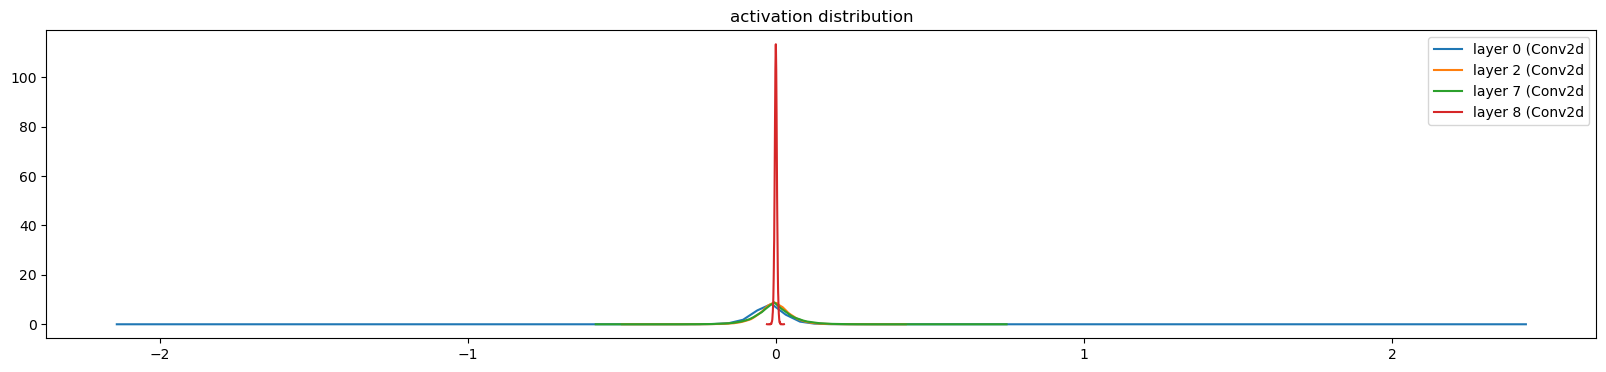

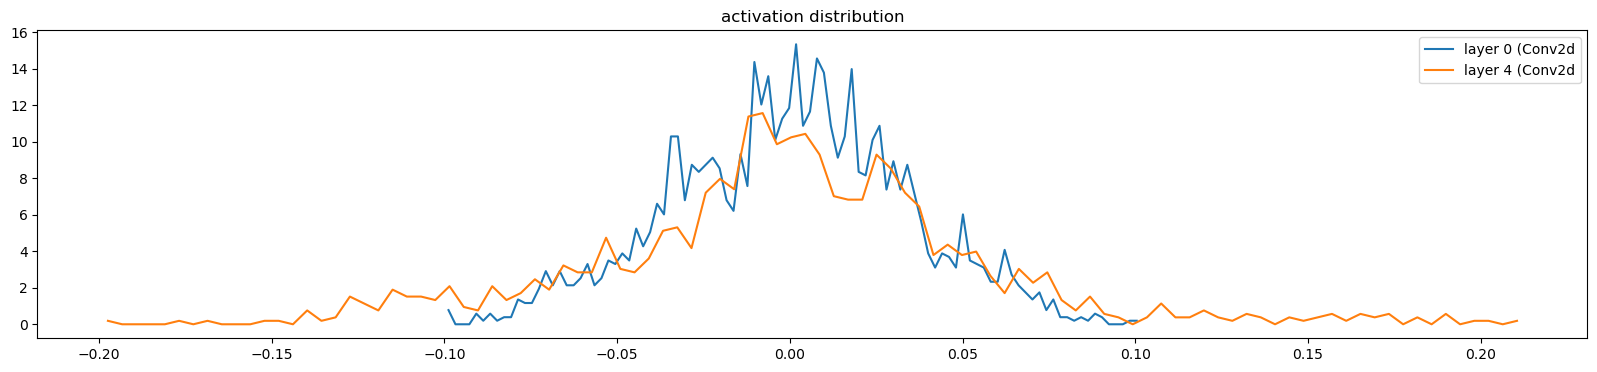

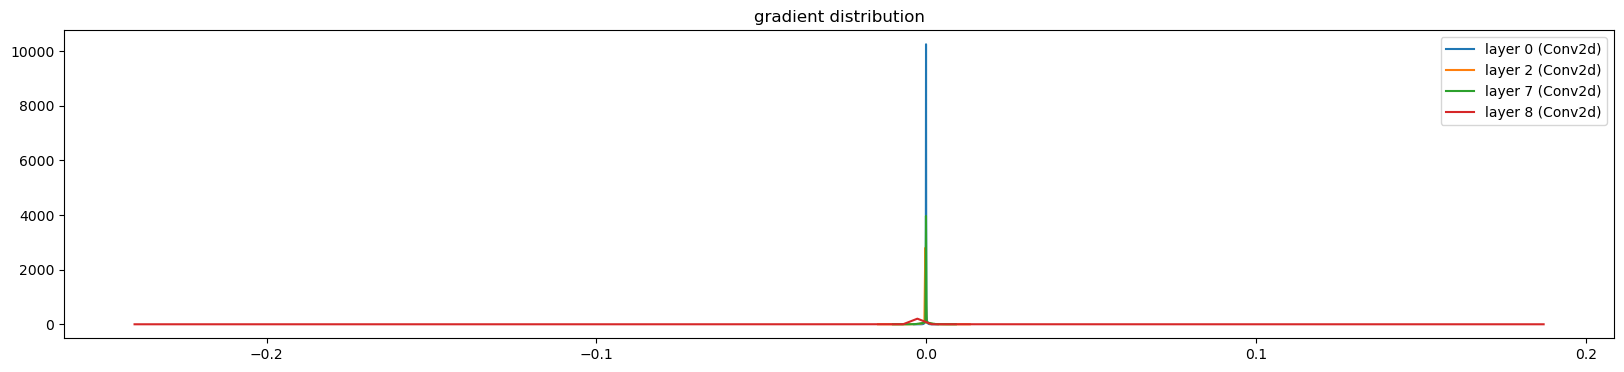

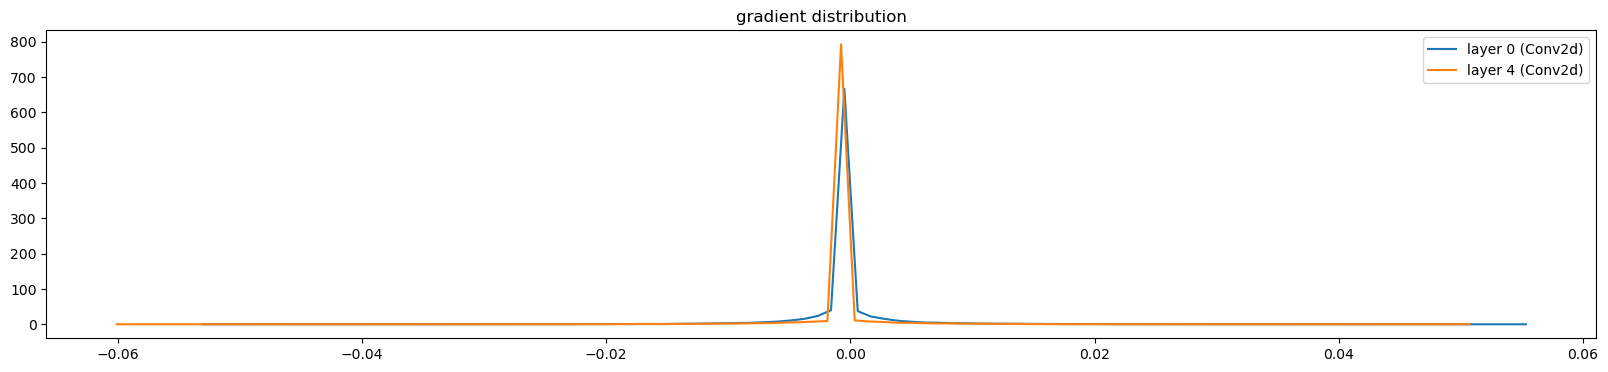

In [135]:
# Conv2d Activations and their gradients

plt.figure(figsize=(20, 4)); # width and height of the plot
legends = []
for i, layer in enumerate(eeg_encoder[:-1]): # note: exclude the output layer
    if isinstance(layer, (Conv2d)):
        t = layer.out
        print('layer %d (%10s):  mean  %+f, std %e, range [%e  %e]' % (i, layer.__class__.__name__, t.mean(), t.std(), t.min(), t.max()))
        print(t.shape)
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
    plt.legend(legends);
    plt.title('activation distribution')


plt.figure(figsize=(20, 4)); # width and height of the plot
legends = []
for i, layer in enumerate(env_encoder[:-1]): # note: exclude the output layer
    if isinstance(layer, (Conv2d)):
        t = layer.out
        print('layer %d (%10s):  mean  %+f, std %e, range [%e  %e]' % (i, layer.__class__.__name__, t.mean(), t.std(), t.min(), t.max()))
        print(t.shape)
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
    plt.legend(legends);
    plt.title('activation distribution')


plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(eeg_encoder[:-1]): # note: exclude the output layer
    if isinstance(layer, Conv2d):
        t = layer.out.grad
        print('layer %d (%10s):  mean  %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
    plt.legend(legends);
    plt.title('gradient distribution')


plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(env_encoder[:-1]): # note: exclude the output layer
    if isinstance(layer, Conv2d):
        t = layer.out.grad
        print('layer %d (%10s):  mean  %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
    plt.legend(legends);
    plt.title('gradient distribution')

weight (8, 1, 1, 32) | mean +0.000110 | std 4.187722e-03 | grad:data ratio 4.104975e-02
weight (16, 1, 64, 1) | mean -0.000000 | std 1.628790e-03 | grad:data ratio 2.013241e-02
weight (16, 1, 1, 8) | mean -0.000381 | std 9.939726e-03 | grad:data ratio 7.911483e-02
weight (16, 16, 1, 1) | mean +0.000200 | std 5.999943e-03 | grad:data ratio 6.570660e-02


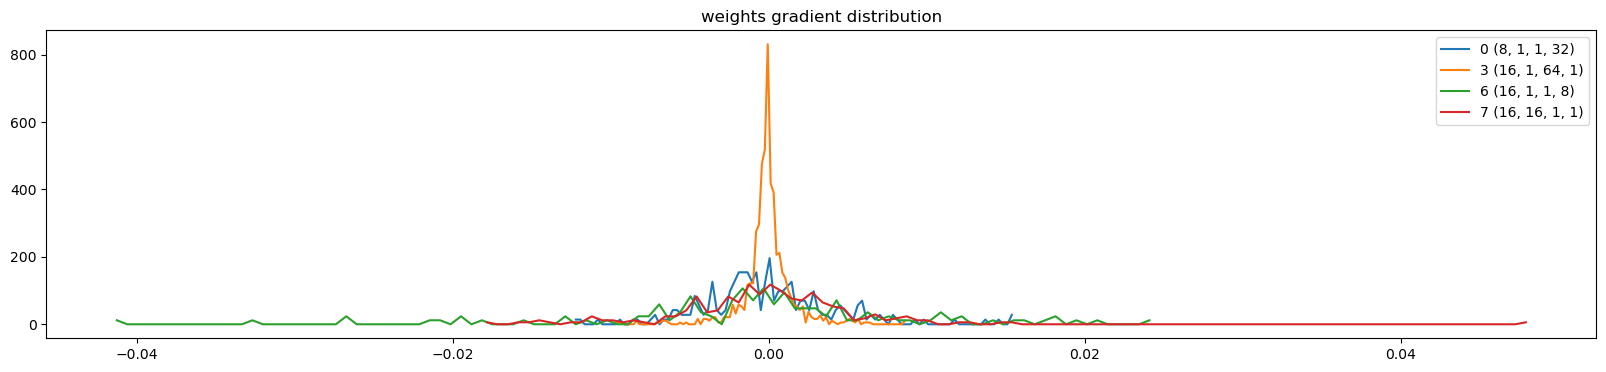

In [96]:

# Visualize weights and their gradients

plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, p in enumerate(eeg_encoder.parameters()):
    t = p.grad
    #print(i, t.shape)
    if p.ndim == 4:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std() ))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
    plt.legend(legends);
    plt.title('weights gradient distribution')

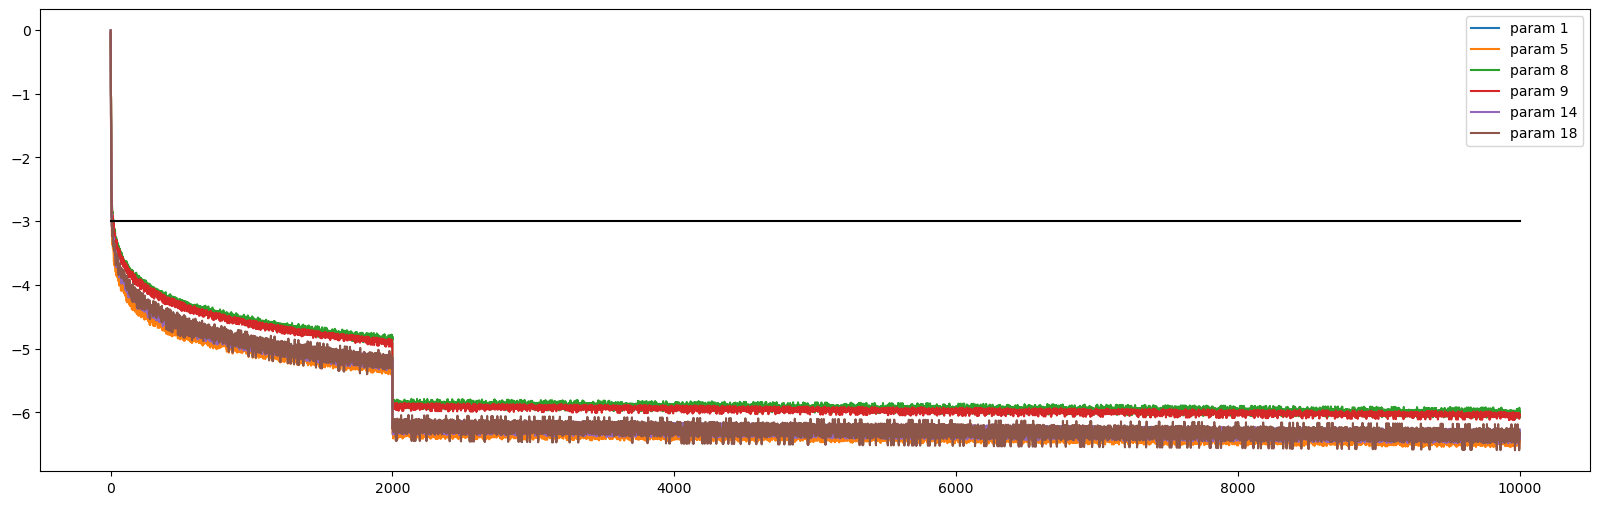

In [22]:
plt.figure(figsize=(20, 6))
legends = []
for i, p in enumerate(model.parameters()):
    if p.ndim == 4:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these rations should be ~1e-3, indicate on plot.
plt.legend(legends);

In [200]:
for n, p in EEGNet.named_parameters():
    if p.ndim == 4:
        print(n, torch.norm(p, dim=(2, 3)))
normalize_weights_eegnet(EEGNet)
for n, p in EEGNet.named_parameters():
    if p.ndim == 4:
        print(n, torch.norm(p, dim=(2, 3)))

weight tensor([[0.6915],
        [0.5577],
        [0.5278],
        [0.6320]], grad_fn=<SqrtBackward0>)
weight tensor([[0.5939],
        [0.5884],
        [0.5696],
        [0.5520],
        [0.5900],
        [0.5421],
        [0.5889],
        [0.6125],
        [0.5165],
        [0.5998],
        [0.4708],
        [0.6053],
        [0.5850],
        [0.5686],
        [0.5670],
        [0.5600]], grad_fn=<SqrtBackward0>)
weight tensor([[0.4558],
        [0.5600],
        [0.5151],
        [0.6034],
        [0.5388],
        [0.5390],
        [0.3890],
        [0.6365],
        [0.5950],
        [0.5377],
        [0.4516],
        [0.5553],
        [0.4037],
        [0.6745],
        [0.4414],
        [0.4887]], grad_fn=<SqrtBackward0>)
weight tensor([[0.0491, 0.1157, 0.2164, 0.2400, 0.1556, 0.0537, 0.0910, 0.0323, 0.0212,
         0.1013, 0.0759, 0.2010, 0.2058, 0.1035, 0.1619, 0.0795],
        [0.2160, 0.2353, 0.0962, 0.2443, 0.0362, 0.0147, 0.1257, 0.0918, 0.0193,
         0.2174, 0

In [170]:
def normalize_weights_eegnet(model, norm_rate=4, eps=1e-8):
    with torch.no_grad():
        for name, param in model.named_parameters():
            if 'depthwise_conv1.weight' in name:
                param.copy_(param / (eps + param.norm(2, dim=(2, 3), keepdim=True)))
                #print(model.depthwise_conv1.weight.norm(2, dim=(2, 3)))
            if name == 'fc.weight' in name:
                param.copy_(param / (eps + norm_rate * param.norm(2, dim=1, keepdim=True)))
            #print(model.depthwise_conv1.weight.data[0, :, :, :].squeeze())

'bias'

In [154]:

EEGNet.named_parameters()[0][0]


TypeError: 'zip' object is not subscriptable

In [162]:
# EEGNet
########################################################################################################################
class EEGNet(nn.Module):
    def __init__(self, fs=64, T=64*5, F1=8, D=2, C=42, F2=None, dropout_rate=0.25):
        super(EEGNet, self).__init__()

        self.dropout_rate = dropout_rate

        # Block 1
        kernel_conv = (1, int(fs/2)-1)
        pad_conv = (0, int((kernel_conv[1]-1)/2)) # Since the kernel is one-dimensional, no need to pad along the 1 dimension
        in_channels = 1  # Here channel refers to depth NOT channels of EEG data

        # Here groups is specified to in_channels to implement depthwise convolution (no summation over channels)
        # However doesn't matter here as in_channels=1
        self.conv = nn.Conv2d(in_channels, F1, kernel_conv, padding=pad_conv, bias=False, groups=1)
        self.batchnorm1 = nn.BatchNorm2d(F1, affine=False)
        # Here once again a depthwise convolution (separate 2d kernels on each channel is applied)
        self.depthwise_conv1 = nn.Conv2d(in_channels=F1, out_channels=D*F1, kernel_size=(C, 1), padding=(0, 0), bias=False, groups=F1)
        self.batchnorm2 = nn.BatchNorm2d(D*F1, affine=False)
        self.avgpooling1 = nn.AvgPool2d(1, 4)


        # Block 2
        k_conv3 = (1, int(fs/(2*4))-1)
        pad_conv3 = (0, int((k_conv3[1]-1)/2))

        if not F2:
            F2 = D * F1  # Page 6 paragraph 3 of paper

        self.depthwise_conv2 = nn.Conv2d(D*F1, D*F1, k_conv3, padding=pad_conv3, bias=False, groups=D*F1)
        # For pointwise covolution, groups is set to 1, in order to apply a 3d kernel, summing over all channels
        self.pointwise_conv = nn.Conv2d(D*F1, F2, kernel_size=(1, 1), padding=(0, 0), groups=1, bias=False)
        self.batchnorm3 = nn.BatchNorm2d(F2, affine=False)
        self.avgpooling2 = nn.AvgPool2d(1, 8)

        # Fully Connected Layer
        self.fc = nn.Linear(F2*int(T//(4*8)), 1)

    def forward(self, x):

        dropout_rate = self.dropout_rate

        # Block 1
        x = self.conv(x)
        x = self.batchnorm1(x)
        x = self.depthwise_conv1(x)
        x = self.batchnorm2(x)
        x = F.elu(x)
        x = self.avgpooling1(x)
        x = F.dropout(x, dropout_rate)

        # Block 2
        x = self.depthwise_conv2(x)
        x = self.pointwise_conv(x)
        x = self.batchnorm3(x)
        x = F.elu(x)
        x = self.avgpooling2(x)
        x = F.dropout(x, dropout_rate)


        # Fully connected layer
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        out = torch.sigmoid(x).squeeze()
        return out


def normalize_weights_eegnet(model, norm_rate=4, eps=1e-8):
    # Double check gradients ...
    #print('wc applied!')
    with torch.no_grad():
        for name, param in model.named_parameters():
            if 'depthwise_conv1.weight' in name:
                param.copy_(param / (eps + param.norm(2, dim=(2, 3), keepdim=True)))
                #print(model.depthwise_conv1.weight.norm(2, dim=(2, 3)))
            if name == 'fc.weight' in name:
                param.copy_(param / (eps + norm_rate * param.norm(2, dim=1, keepdim=True)))
            #print(model.depthwise_conv1.weight.data[0, :, :, :].squeeze())

In [142]:
import numpy as np
from torch import nn
from torch.nn import init

import braindecode

from braindecode.util import np_to_th
from braindecode.models.modules import Expression, Ensure4d
from braindecode.models.functions import (
    safe_log, square, transpose_time_to_spat, squeeze_final_output
)


class ShallowFBCSPNet(nn.Sequential):
    """Shallow ConvNet model from Schirrmeister et al 2017.
    Model described in [Schirrmeister2017]_.
    Parameters
    ----------
    in_chans : int
        Number of EEG input channels.
    n_classes: int
        Number of classes to predict (number of output filters of last layer).
    input_window_samples: int | None
        Only used to determine the length of the last convolutional kernel if
        final_conv_length is "auto".
    n_filters_time: int
        Number of temporal filters.
    filter_time_length: int
        Length of the temporal filter.
    n_filters_spat: int
        Number of spatial filters.
    pool_time_length: int
        Length of temporal pooling filter.
    pool_time_stride: int
        Length of stride between temporal pooling filters.
    final_conv_length: int | str
        Length of the final convolution layer.
        If set to "auto", input_window_samples must not be None.
    conv_nonlin: callable
        Non-linear function to be used after convolution layers.
    pool_mode: str
        Method to use on pooling layers. "max" or "mean".
    pool_nonlin: callable
        Non-linear function to be used after pooling layers.
    split_first_layer: bool
        Split first layer into temporal and spatial layers (True) or just use temporal (False).
        There would be no non-linearity between the split layers.
    batch_norm: bool
        Whether to use batch normalisation.
    batch_norm_alpha: float
        Momentum for BatchNorm2d.
    drop_prob: float
        Dropout probability.
         """

    def __init__(
        self,
        in_chans,
        n_classes,
        input_window_samples=None,
        n_filters_time=40,
        filter_time_length=25,
        n_filters_spat=40,
        pool_time_length=75,
        pool_time_stride=15,
        final_conv_length=30,
        conv_nonlin=square,
        pool_mode="mean",
        pool_nonlin=safe_log,
        split_first_layer=True,
        batch_norm=True,
        batch_norm_alpha=0.1,
        drop_prob=0.5,
    ):
        super().__init__()
        if final_conv_length == "auto":
            assert input_window_samples is not None
        self.in_chans = in_chans
        self.n_classes = n_classes
        self.input_window_samples = input_window_samples
        self.n_filters_time = n_filters_time
        self.filter_time_length = filter_time_length
        self.n_filters_spat = n_filters_spat
        self.pool_time_length = pool_time_length
        self.pool_time_stride = pool_time_stride
        self.final_conv_length = final_conv_length
        self.conv_nonlin = conv_nonlin
        self.pool_mode = pool_mode
        self.pool_nonlin = pool_nonlin
        self.split_first_layer = split_first_layer
        self.batch_norm = batch_norm
        self.batch_norm_alpha = batch_norm_alpha
        self.drop_prob = drop_prob

        self.add_module("ensuredims", Ensure4d())
        pool_class = dict(max=nn.MaxPool2d, mean=nn.AvgPool2d)[self.pool_mode]

        if self.split_first_layer:
            self.add_module("dimshuffle", Expression(transpose_time_to_spat))
            self.add_module(
                "conv_time",
                nn.Conv2d(
                    1,
                    self.n_filters_time,
                    (self.filter_time_length, 1),
                    stride=1,
                ),
            )
            self.add_module(
                "conv_spat",
                nn.Conv2d(
                    self.n_filters_time,
                    self.n_filters_spat,
                    (1, self.in_chans),
                    stride=1,
                    bias=not self.batch_norm,
                ),
            )
            n_filters_conv = self.n_filters_spat
        else:
            self.add_module(
                "conv_time",
                nn.Conv2d(
                    self.in_chans,
                    self.n_filters_time,
                    (self.filter_time_length, 1),
                    stride=1,
                    bias=not self.batch_norm,
                ),
            )
            n_filters_conv = self.n_filters_time

        if self.batch_norm:
            self.add_module(
                "bnorm",
                nn.BatchNorm2d(
                    n_filters_conv, momentum=self.batch_norm_alpha, affine=True
                ),
            )
        self.add_module("conv_nonlin_exp", Expression(self.conv_nonlin))
        self.add_module(
            "pool",
            pool_class(
                kernel_size=(self.pool_time_length, 1),
                stride=(self.pool_time_stride, 1),
            ),
        )
        self.add_module("pool_nonlin_exp", Expression(self.pool_nonlin))
        self.add_module("drop", nn.Dropout(p=self.drop_prob))
        self.eval()
        if self.final_conv_length == "auto":
            out = self(
                np_to_th(
                    np.ones(
                        (1, self.in_chans, self.input_window_samples, 1),
                        dtype=np.float32,
                    )
                )
            )
            n_out_time = out.cpu().data.numpy().shape[2]
            self.final_conv_length = n_out_time
        self.add_module(
            "conv_classifier",
            nn.Conv2d(
                n_filters_conv,
                self.n_classes,
                (self.final_conv_length, 1),
                bias=True,
            ),
        )
        self.add_module("softmax", nn.LogSoftmax(dim=1))
        self.add_module("squeeze", Expression(squeeze_final_output))

        # Initialization, xavier is same as in paper...
        init.xavier_uniform_(self.conv_time.weight, gain=1)
        # maybe no bias in case of no split layer and batch norm
        if self.split_first_layer or (not self.batch_norm):
            init.constant_(self.conv_time.bias, 0)
        if self.split_first_layer:
            init.xavier_uniform_(self.conv_spat.weight, gain=1)
            if not self.batch_norm:
                init.constant_(self.conv_spat.bias, 0)
        if self.batch_norm:
            init.constant_(self.bnorm.weight, 1)
            init.constant_(self.bnorm.bias, 0)
        init.xavier_uniform_(self.conv_classifier.weight, gain=1)
        init.constant_(self.conv_classifier.bias, 0)

In [ ]:
lre = torch.linspace(-3, 0, 100)
lrs = 10**lre # Exponentialy spaced!

# Now let's update the previous code
lri = []
lrei = [] # this is just for education
lossi = []
for i in range(100):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    Xb, Yb = Xtr, ytr#[ix] # batch X, Y

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function
    print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad =  None
    loss.backward()

    # Update 
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

        # normalize weights
    #normalize_weights_eegnet(model)

    # track stats
    lri.append(lr)
    lrei.append(lre[i])
    lossi.append(loss.item())

print(loss.item())
